In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import gradio as gr

In [27]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load the train dataset (model isn't trained on this dataset)

batch_size = 1000
test_dataset = datasets.MNIST(root="../data", train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

In [29]:
class DigitNetVisualizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, X):
        x1 = F.relu(self.conv1(X))  # after conv1
        p1 = self.pool1(x1)         # after pool1
        
        x2 = F.relu(self.conv2(p1)) # after conv2
        p2 = self.pool2(x2)         # after pool2
        
        flat = p2.view(-1, 64 * 7 * 7)
        fc1_out = F.relu(self.fc1(flat))
        out = self.fc2(fc1_out)

        # return both final output and intermediate features
        return out, {"conv1": x1, "pool1": p1, "conv2": x2, "pool2": p2}    


In [30]:
model = DigitNetVisualizer()
model.load_state_dict(torch.load("../models/model_weights.pth", weights_only=True))
model.eval()

DigitNetVisualizer(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Visualization

In [115]:
index = 100

In [116]:
dummy = test_dataset.data[index].type(torch.float32)

with torch.inference_mode():
    y_logits, feats = model(dummy.unsqueeze(0))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs)

In [117]:
def show_layer_output(layer, r, c):
    n = feats[layer].shape[0]
    fig, axes = plt.subplots(r, c, figsize=(20,10))
    axes = axes.reshape(-1)

    for i in range(n):
        axes[i].imshow(feats[layer][i].cpu(), cmap="gray")
        axes[i].axis("off")

    plt.show()

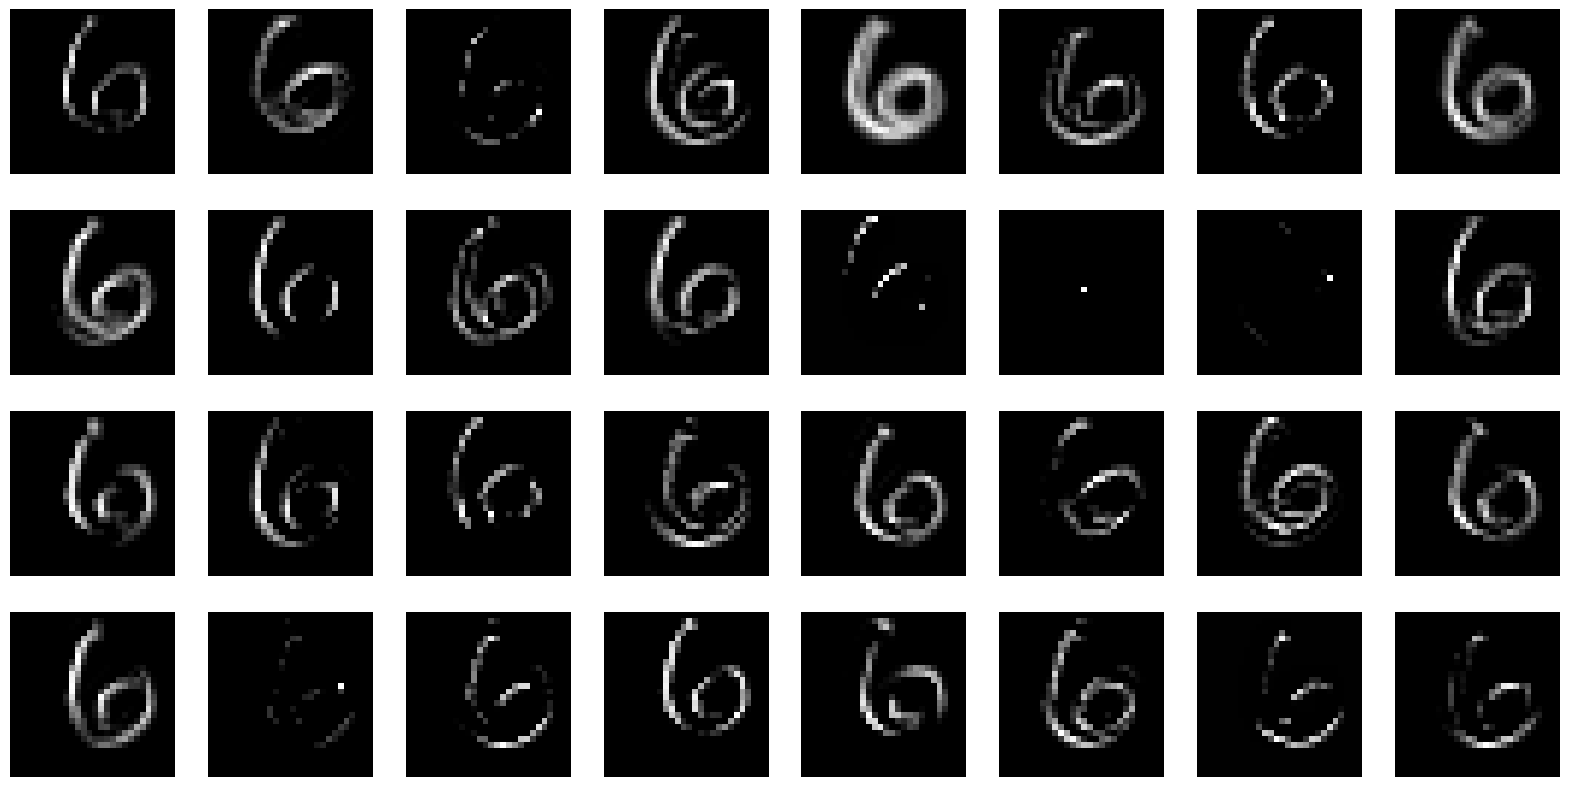

In [118]:
show_layer_output("conv1", 4, 8)

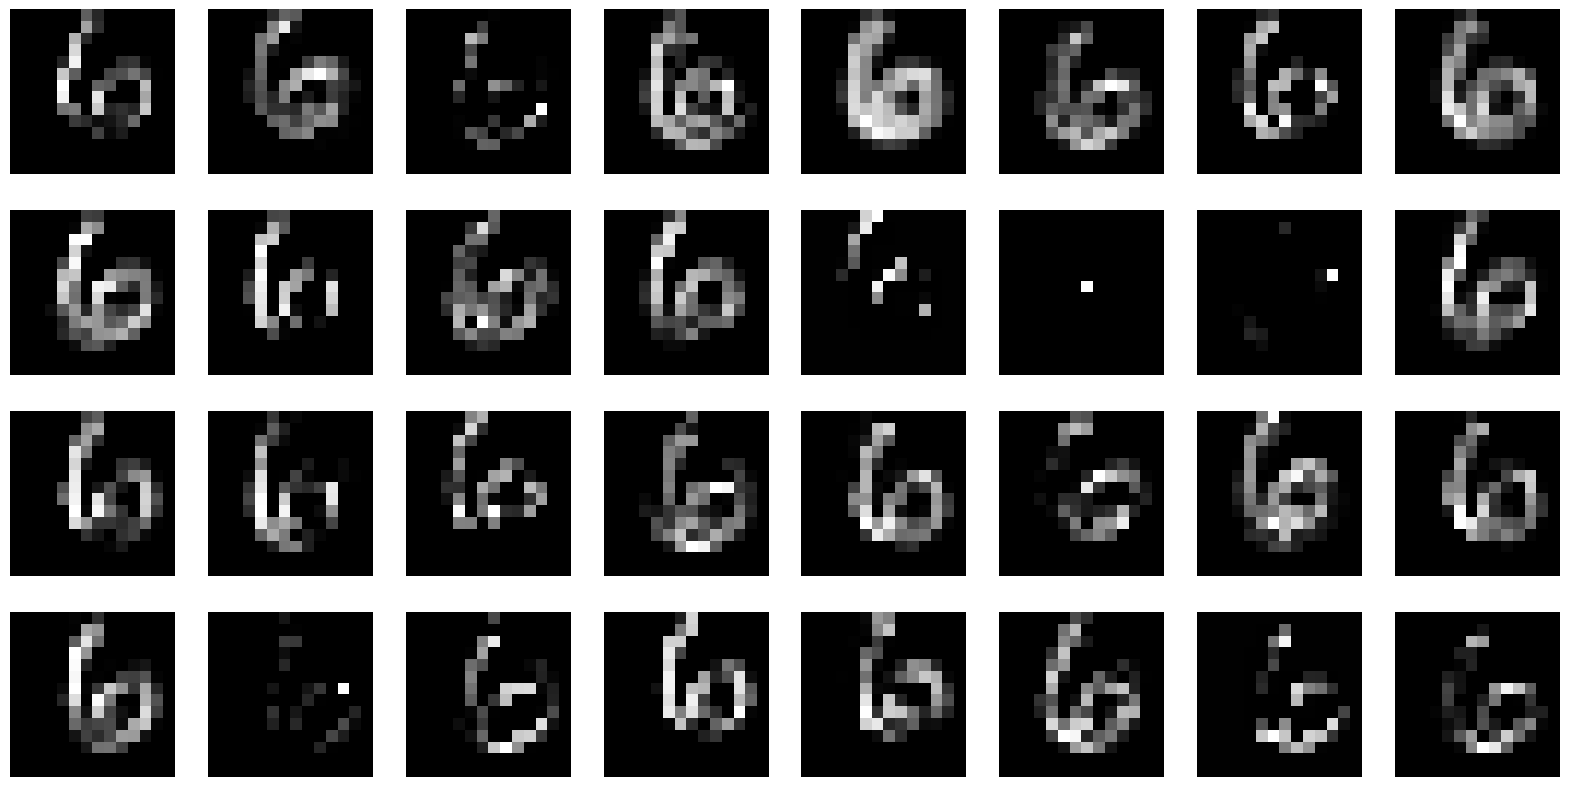

In [119]:
show_layer_output("pool1", 4, 8)

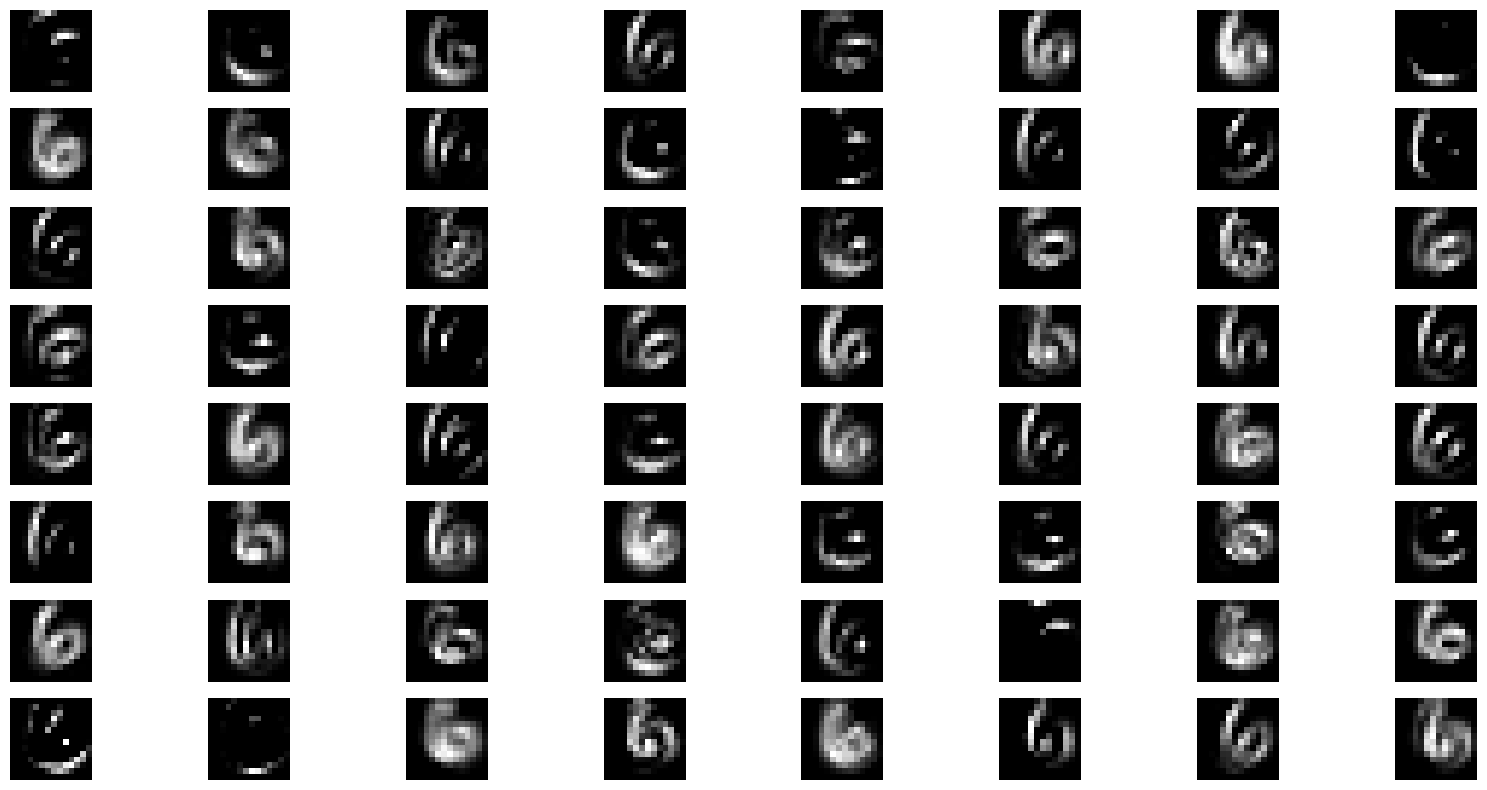

In [120]:
show_layer_output("conv2", 8, 8)

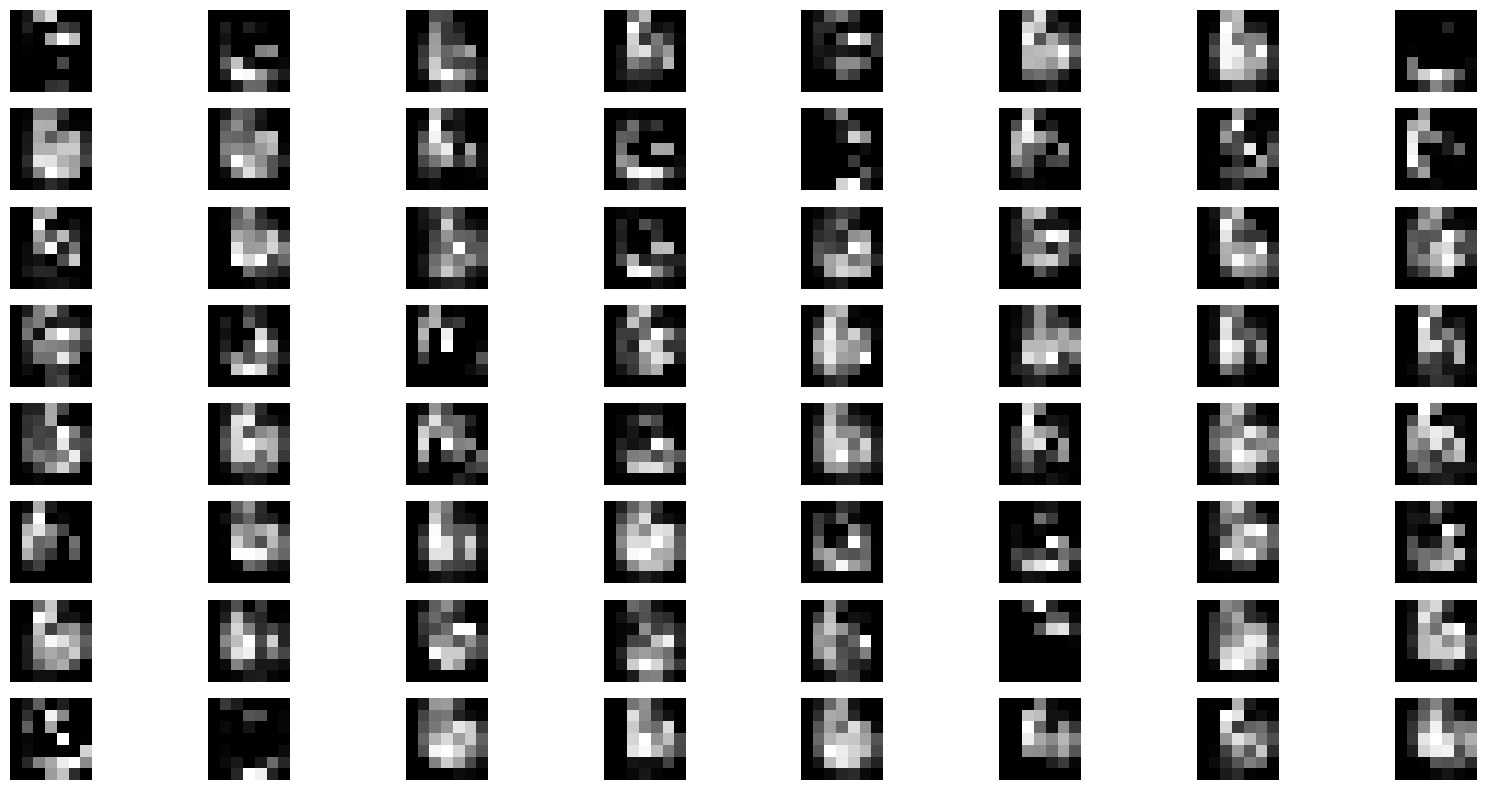

In [121]:
show_layer_output("pool2", 8, 8)

In [122]:
y_pred_probs

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [123]:
print(f"Prediction: {y_pred.item()}")

Prediction: 6
